# 02 - ML Experimentation with Custom Model

The purpose of this notebook is to use [custom training](https://cloud.google.com/ai-platform-unified/docs/training/custom-training) to train a keras classifier to predict whether a given trip will result in a tip > 20%. The notebook covers the following tasks:
1. Preprocess the data locally using Apache Beam.
2. Train and test custom model locally using a Keras implementation.
3. Submit a Dataflow job to preprocess the data at scale.
4. Submit a custom training job to Vertex AI using a [pre-built container](https://cloud.google.com/ai-platform-unified/docs/training/pre-built-containers).
5. Upload the trained model to Vertex AI.
6. Track experiment parameters from [Vertex AI Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata/introduction).
7. Submit a [hyperparameter tuning job](https://cloud.google.com/vertex-ai/docs/training/hyperparameter-tuning-overview) to Vertex AI.

We use [Vertex TensorBoard](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview) 
and [Vertex ML Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata/introduction) to  track, visualize, and compare ML experiments.

## Setup

### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

import os
import logging
from datetime import datetime
import numpy as np

import tensorflow as tf
import tensorflow_transform as tft
import tensorflow.keras as keras

from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform import hyperparameter_tuning as hp_tuning

from src.common import features, datasource_utils
from src.model_training import data, model, defaults, trainer, exporter
from src.preprocessing import etl

logging.getLogger().setLevel(logging.INFO)
tf.get_logger().setLevel('INFO')

print(f"TensorFlow: {tf.__version__}")
print(f"TensorFlow Transform: {tft.__version__}")

TensorFlow: 2.8.1
TensorFlow Transform: 1.8.0


### Setup Google Cloud project

In [47]:
PROJECT = 'pbalm-cxb-aa'
REGION = 'europe-west4'
BUCKET = PROJECT + '-eu'
SERVICE_ACCOUNT = "188940921537-compute@developer.gserviceaccount.com"
#SERVICE_ACCOUNT = "sa-mlops@cxb1-prj-test-no-vpcsc.iam.gserviceaccount.com"
#SERVICE_ACCOUNT = "" # This will trigger use of user account


if PROJECT == "" or PROJECT is None or PROJECT == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT = shell_output[0]
    
if SERVICE_ACCOUNT == "" or SERVICE_ACCOUNT is None or SERVICE_ACCOUNT == "[your-service-account]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.account)' 2>/dev/null
    SERVICE_ACCOUNT = shell_output[0]
    
if BUCKET == "" or BUCKET is None or BUCKET == "[your-bucket-name]":
    # Get your bucket name to GCP projet id
    BUCKET = PROJECT
    # Try to create the bucket if it doesn'exists
    ! gsutil mb -l $REGION gs://$BUCKET
    print("")
    
PARENT = f"projects/{PROJECT}/locations/{REGION}"
    
print("Project ID:", PROJECT)
print("Region:", REGION)
print("Bucket name:", BUCKET)
print("Service Account:", SERVICE_ACCOUNT)
print("Vertex API Parent URI:", PARENT)

Project ID: pbalm-cxb-aa
Region: europe-west4
Bucket name: pbalm-cxb-aa-eu
Service Account: 188940921537-compute@developer.gserviceaccount.com
Vertex API Parent URI: projects/pbalm-cxb-aa/locations/europe-west4


### Set configurations

In [48]:
VERSION = 'v01'
VERTEX_DATASET_NAME = 'creditcards'

MODEL_DISPLAY_NAME = f'{VERTEX_DATASET_NAME}-classifier-{VERSION}'

WORKSPACE = f'gs://{BUCKET}/{VERTEX_DATASET_NAME}'
EXPERIMENT_ARTIFACTS_DIR = os.path.join(WORKSPACE, 'experiments')
RAW_SCHEMA_LOCATION = 'src/raw_schema/schema.pbtxt'

TENSORBOARD_DISPLAY_NAME = f'tb-{VERTEX_DATASET_NAME}'
EXPERIMENT_NAME = f'{MODEL_DISPLAY_NAME}'
DATAFLOW_REGION = f'{REGION}'
DATAFLOW_SERVICE_ACCOUNT = SERVICE_ACCOUNT
#DATAFLOW_SUBNETWORK = 'https://www.googleapis.com/compute/v1/projects/cxb1-prj-test-no-vpcsc/regions/europe-west1/subnetworks/default'
DATAFLOW_SUBNETWORK = 'https://www.googleapis.com/compute/v1/projects/pbalm-cxb-aa/regions/europe-west4/subnetworks/default'

if not REGION in DATAFLOW_SUBNETWORK:
    raise Exception(f'{DATAFLOW_SUBNETWORK} is not a valid subnet for {REGION}')


## Create Vertex TensorBoard instance 

In [4]:
vertex_ai.init(location=REGION)
tensorboard_resource = vertex_ai.Tensorboard.create(display_name=TENSORBOARD_DISPLAY_NAME)
tensorboard_resource_name = tensorboard_resource.gca_resource.name
print("TensorBoard resource name:", tensorboard_resource_name)

Creating Tensorboard
Create Tensorboard backing LRO: projects/188940921537/locations/europe-west4/tensorboards/6937971147824693248/operations/1166098601709928448
Tensorboard created. Resource name: projects/188940921537/locations/europe-west4/tensorboards/6937971147824693248
To use this Tensorboard in another session:
tb = aiplatform.Tensorboard('projects/188940921537/locations/europe-west4/tensorboards/6937971147824693248')
TensorBoard resource name: projects/188940921537/locations/europe-west4/tensorboards/6937971147824693248


## Initialize workspace

In [49]:
REMOVE_EXPERIMENT_ARTIFACTS = False

if tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR) and REMOVE_EXPERIMENT_ARTIFACTS:
    print("Removing previous experiment artifacts...")
    tf.io.gfile.rmtree(EXPERIMENT_ARTIFACTS_DIR)

if not tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR):
    print("Creating new experiment artifacts directory...")
    tf.io.gfile.mkdir(EXPERIMENT_ARTIFACTS_DIR)

print("Workspace is ready.")
print("Experiment directory:", EXPERIMENT_ARTIFACTS_DIR)

Workspace is ready.
Experiment directory: gs://pbalm-cxb-aa-eu/creditcards/experiments


## Initialize Vertex AI experiment

In [50]:
vertex_ai.init(
    project=PROJECT,
    location=REGION,
    staging_bucket=BUCKET,
    experiment=EXPERIMENT_NAME
)

run_id = f"run-local-{datetime.now().strftime('%Y%m%d%H%M%S')}"
vertex_ai.start_run(run_id)

EXPERIMENT_RUN_DIR = os.path.join(EXPERIMENT_ARTIFACTS_DIR, EXPERIMENT_NAME, run_id)
print("Experiment run directory:", EXPERIMENT_RUN_DIR)

Experiment run directory: gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-local-20220628132213


## 1. Preprocess the data using Apache Beam

The Apache Beam pipeline of data preprocessing is implemented in the [preprocessing](src/preprocessing) directory.

In [51]:
EXPORTED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'exported_data')
TRANSFORMED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'transformed_data')
TRANSFORM_ARTIFACTS_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'transform_artifacts')

### Get Source Query from Managed Dataset

In [52]:
ML_USE = 'UNASSIGNED'
LIMIT = 5120

raw_data_query = datasource_utils.get_training_source_query(
    project=PROJECT, 
    region=REGION, 
    dataset_display_name=VERTEX_DATASET_NAME, 
    ml_use=ML_USE, 
    limit=LIMIT
)

print(raw_data_query)


    SELECT *
    
    EXCEPT (Time, ML_use)
    FROM vertex_eu.creditcards_ml 
    WHERE ML_use = 'UNASSIGNED'
    LIMIT 5120


### Test Data Preprocessing Locally

In [53]:
args = {
    'runner': 'DirectRunner',
    'raw_data_query': raw_data_query,
    'write_raw_data': True,
    'exported_data_prefix': EXPORTED_DATA_PREFIX,
    'transformed_data_prefix': TRANSFORMED_DATA_PREFIX,
    'transform_artifact_dir': TRANSFORM_ARTIFACTS_DIR,
    'temporary_dir': os.path.join(WORKSPACE, 'tmp'),
    'gcs_location': f'gs://{BUCKET}/bq_tmp',
    'project': PROJECT,
    'region': REGION
}

In [54]:
vertex_ai.log_params(args)

In [55]:
print("Data preprocessing started...")
etl.run_transform_pipeline(args)
print("Data preprocessing completed.")

Data preprocessing started...


INFO:tensorflow:Assets written to: gs://pbalm-cxb-aa-eu/creditcards/tmp/tftransform_tmp/959a12e58f5e4c289d6817dc4abf7685/assets


INFO:tensorflow:Assets written to: gs://pbalm-cxb-aa-eu/creditcards/tmp/tftransform_tmp/959a12e58f5e4c289d6817dc4abf7685/assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:Assets written to: gs://pbalm-cxb-aa-eu/creditcards/tmp/tftransform_tmp/196a19992f7e46ac8722750356fff3b9/assets


INFO:tensorflow:Assets written to: gs://pbalm-cxb-aa-eu/creditcards/tmp/tftransform_tmp/196a19992f7e46ac8722750356fff3b9/assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


Data preprocessing completed.


In [56]:
!gsutil ls {EXPERIMENT_RUN_DIR}

gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-local-20220628132213/exported_data/
gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-local-20220628132213/transform_artifacts/
gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-local-20220628132213/transformed_data/


## 2. Train a custom model locally using a Keras

The `Keras` implementation of the custom model is in the [model_training](src/model_training) directory.

In [57]:
LOG_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'logs')
EXPORT_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'model')

### Read transformed data

In [58]:
tft_output = tft.TFTransformOutput(TRANSFORM_ARTIFACTS_DIR)
transform_feature_spec = tft_output.transformed_feature_spec()
transform_feature_spec

{'Amount': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'Class': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'V1': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'V10': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'V11': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'V12': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'V13': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'V14': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'V15': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'V16': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'V17': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'V18': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'V19': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'V2': FixedLenFeature(shape=[1], 

In [59]:
train_data_file_pattern = os.path.join(TRANSFORMED_DATA_PREFIX,'train/data-*.gz')
eval_data_file_pattern = os.path.join(TRANSFORMED_DATA_PREFIX,'eval/data-*.gz')

train_data_file_pattern

'gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-local-20220628132213/transformed_data/train/data-*.gz'

In [60]:
for input_features, target in data.get_dataset(train_data_file_pattern, transform_feature_spec, batch_size=3).take(1):
    for key in input_features:
        print(f"{key} {input_features[key].dtype}: {input_features[key].numpy().tolist()}")
    print(f"target: {target.numpy().tolist()}")

Amount <dtype: 'float32'>: [[0.5530469417572021], [-1.2997244596481323], [-0.31157970428466797]]
V1 <dtype: 'float32'>: [[0.9349209070205688], [0.891810953617096], [0.9927675724029541]]
V10 <dtype: 'float32'>: [[0.5361246466636658], [0.5891866683959961], [0.5728040933609009]]
V11 <dtype: 'float32'>: [[0.44999223947525024], [0.13883373141288757], [0.26316753029823303]]
V12 <dtype: 'float32'>: [[0.9115099310874939], [0.7992635369300842], [0.7506637573242188]]
V13 <dtype: 'float32'>: [[0.6656832098960876], [0.6401777863502502], [0.42388156056404114]]
V14 <dtype: 'float32'>: [[0.7040902376174927], [0.703034520149231], [0.7349112629890442]]
V15 <dtype: 'float32'>: [[0.5309087038040161], [0.4936237037181854], [0.6177024841308594]]
V16 <dtype: 'float32'>: [[0.795793890953064], [0.7409265041351318], [0.8301047682762146]]
V17 <dtype: 'float32'>: [[0.7375094294548035], [0.7765122652053833], [0.7727304100990295]]
V18 <dtype: 'float32'>: [[0.7343204617500305], [0.6878483891487122], [0.526848196983

### Create hyperparameters

In [61]:
hyperparams = {
    "hidden_units": [64, 32]
}

hyperparams = defaults.update_hyperparams(hyperparams)
hyperparams

{'hidden_units': [64, 32],
 'learning_rate': 0.0001,
 'batch_size': 512,
 'num_epochs': 10}

### Create and test model inputs and outputs

In [62]:
classifier = model.create_model(transform_feature_spec.keys(), hyperparams)

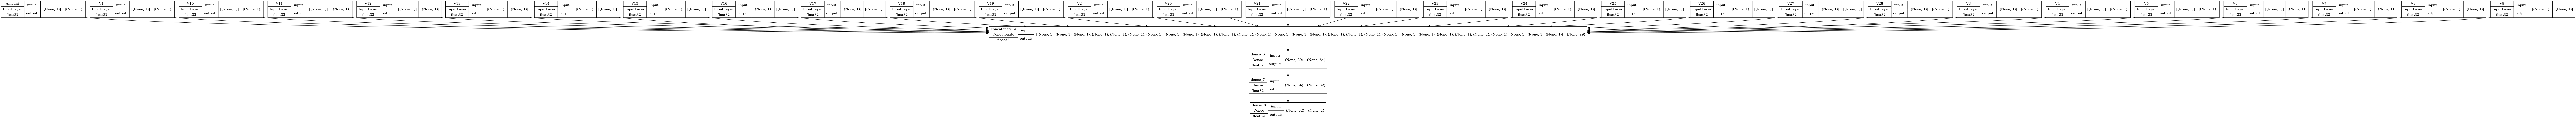

In [63]:
keras.utils.plot_model(
    classifier, 
    show_shapes=True, 
    show_dtype=True
)

In [64]:
classifier(input_features)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.46825898],
       [0.42137378],
       [0.4523844 ]], dtype=float32)>

In [65]:
input_features

{'Amount': <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[ 0.55304694],
        [-1.2997245 ],
        [-0.3115797 ]], dtype=float32)>,
 'V1': <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.9349209 ],
        [0.89181095],
        [0.9927676 ]], dtype=float32)>,
 'V10': <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.53612465],
        [0.58918667],
        [0.5728041 ]], dtype=float32)>,
 'V11': <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.44999224],
        [0.13883373],
        [0.26316753]], dtype=float32)>,
 'V12': <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.91150993],
        [0.79926354],
        [0.75066376]], dtype=float32)>,
 'V13': <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.6656832 ],
        [0.6401778 ],
        [0.42388156]], dtype=float32)>,
 'V14': <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.70409024],
        [0.7030345 ],
        [0.73491126]], dtype=float32)>,
 'V15': <tf.Ten

### Train the model locally.

In [66]:
logging.getLogger().setLevel(logging.INFO)

hyperparams["learning_rate"] = 0.001
hyperparams["num_epochs"] = 5
hyperparams["batch_size"] = 512

vertex_ai.log_params(hyperparams)

In [67]:
classifier = trainer.train(
    train_data_dir=train_data_file_pattern,
    eval_data_dir=eval_data_file_pattern,
    tft_output_dir=TRANSFORM_ARTIFACTS_DIR,
    hyperparams=hyperparams,
    log_dir=LOG_DIR,
)

INFO:root:Loading tft output from gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-local-20220628132213/transform_artifacts
INFO:root:Model: "model_3"
INFO:root:__________________________________________________________________________________________________
INFO:root: Layer (type)                   Output Shape         Param #     Connected to                     
INFO:root:==================================================================================================
INFO:root: Amount (InputLayer)            [(None, 1)]          0           []                               
INFO:root:                                                                                                  
INFO:root: V1 (InputLayer)                [(None, 1)]          0           []                               
INFO:root:                                                                                                  
INFO:root: V10 (InputLayer)               [(None, 1)]      

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 [==============================] - 3s 278ms/step - loss: 0.5457 - accuracy: 0.9194 - val_loss: 0.4010 - val_accuracy: 0.9961
Epoch 2/5
7/7 [==============================] - 1s 186ms/step - loss: 0.3275 - accuracy: 0.9939 - val_loss: 0.2303 - val_accuracy: 0.9961
Epoch 3/5
7/7 [==============================] - 1s 176ms/step - loss: 0.1859 - accuracy: 0.9939 - val_loss: 0.1256 - val_accuracy: 0.9961
Epoch 4/5
7/7 [==============================] - 1s 176ms/step - loss: 0.1018 - accuracy: 0.9950 - val_loss: 0.0681 - val_accuracy: 0.9961
Epoch 5/5
7/7 [==============================] - 5s 750ms/step - loss: 0.0587 - accuracy: 0.9944 - val_loss: 0.0399 - val_accuracy: 0.9961


2022-06-28 13:24:35.273233: I tensorflow/core/platform/cloud/gcs_file_system.cc:581] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-local-20220628132213/logs/validation/events.out.tfevents.1656422665.mlops2.9926.3.v2
INFO:root:Model training completed.


In [68]:
val_loss, val_accuracy = trainer.evaluate(
    model=classifier,
    data_dir=eval_data_file_pattern,
    raw_schema_location=RAW_SCHEMA_LOCATION,
    tft_output_dir=TRANSFORM_ARTIFACTS_DIR,
    hyperparams=hyperparams,
)

INFO:root:Loading raw schema from src/raw_schema/schema.pbtxt
INFO:root:Loading tft output from gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-local-20220628132213/transform_artifacts
INFO:root:Model evaluation started...


2/2 [==============================] - 0s 46ms/step - loss: 0.0399 - accuracy: 0.9961


INFO:root:Model evaluation completed.


In [69]:
vertex_ai.log_metrics(
    {"val_loss": val_loss, "val_accuracy": val_accuracy})

In [70]:
!tb-gcp-uploader --tensorboard_resource_name={tensorboard_resource_name} \
  --logdir={LOG_DIR} \
  --experiment_name={EXPERIMENT_NAME} --one_shot=True

View your Tensorboard at https://europe-west4.tensorboard.googleusercontent.com/experiment/projects+188940921537+locations+europe-west4+tensorboards+6937971147824693248+experiments+creditcards-classifier-v01
W0628 13:33:42.031495 140358635493184 uploader.py:379] Please consider uploading to a new experiment instead of an existing one, as the former allows for better upload performance.
[2022-06-28T13:33:42] Started scanning logdir.
[2022-06-28T13:33:44] Total uploaded: 30 scalars, 0 tensors, 1 binary objects (35.8 kB)


### Export the trained model

In [71]:
saved_model_dir = os.path.join(EXPORT_DIR)

exporter.export_serving_model(
    classifier=classifier,
    serving_model_dir=saved_model_dir,
    raw_schema_location=RAW_SCHEMA_LOCATION,
    tft_output_dir=TRANSFORM_ARTIFACTS_DIR,
)

INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.
INFO:root:Model export started...


INFO:tensorflow:Assets written to: gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-local-20220628132213/model/assets


INFO:tensorflow:Assets written to: gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-local-20220628132213/model/assets
INFO:root:Model export completed.


### Inspect model serving signatures

In [72]:
!saved_model_cli show --dir={saved_model_dir} --tag_set=serve --signature_def=serving_tf_example

The given SavedModel SignatureDef contains the following input(s):
  inputs['examples'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_tf_example_examples:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['probabilities'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall_1:0
Method name is: tensorflow/serving/predict


In [73]:
!saved_model_cli show --dir={saved_model_dir} --tag_set=serve --signature_def=serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['Amount'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_Amount:0
  inputs['V1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_V1:0
  inputs['V10'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_V10:0
  inputs['V11'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_V11:0
  inputs['V12'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_V12:0
  inputs['V13'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_V13:0
  inputs['V14'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_V14:0
  inputs['V15'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_V15:0
  inputs['V16'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      nam

### Test the exported SavedModel

In [30]:
serving_model = tf.saved_model.load(saved_model_dir)
print("Saved model is loaded.")

Saved model is loaded.


In [31]:
# Test the serving_tf_example with TF Examples

file_names = tf.data.TFRecordDataset.list_files(EXPORTED_DATA_PREFIX + '/data-*.tfrecord')
for batch in tf.data.TFRecordDataset(file_names).batch(3).take(1):
    predictions = serving_model.signatures['serving_tf_example'](batch)
    for key in predictions:
        print(f"{key}: {predictions[key]}")

probabilities: [[0.5103284 ]
 [0.51136553]
 [0.51087755]]


In [32]:
# Test the serving_default with feature dictionary

import tensorflow_data_validation as tfdv
from tensorflow_transform.tf_metadata import schema_utils

raw_schema = tfdv.load_schema_text(RAW_SCHEMA_LOCATION)
raw_feature_spec = schema_utils.schema_as_feature_spec(raw_schema).feature_spec

In [33]:
instance = { 'Amount': 50.0 }

for i in range(1,29):
    instance[f'V{i}'] = 1
    
instance

{'Amount': 50.0,
 'V1': 1,
 'V2': 1,
 'V3': 1,
 'V4': 1,
 'V5': 1,
 'V6': 1,
 'V7': 1,
 'V8': 1,
 'V9': 1,
 'V10': 1,
 'V11': 1,
 'V12': 1,
 'V13': 1,
 'V14': 1,
 'V15': 1,
 'V16': 1,
 'V17': 1,
 'V18': 1,
 'V19': 1,
 'V20': 1,
 'V21': 1,
 'V22': 1,
 'V23': 1,
 'V24': 1,
 'V25': 1,
 'V26': 1,
 'V27': 1,
 'V28': 1}

In [ ]:
for feature_name in instance:
    dtype = raw_feature_spec[feature_name].dtype
    instance[feature_name] = tf.constant([[instance[feature_name]]], dtype)

In [75]:
predictions = serving_model.signatures['serving_default'](**instance)
for key in predictions:
    print(f"{key}: {predictions[key].numpy()}")

classes: [[b'legit' b'fraudulent']]
scores: [[0.50005734 0.49994266]]


## Start a new Vertex AI experiment run

In [76]:
vertex_ai.init(
    project=PROJECT,
    staging_bucket=BUCKET,
    experiment=EXPERIMENT_NAME)

run_id = f"run-gcp-{datetime.now().strftime('%Y%m%d%H%M%S')}"
vertex_ai.start_run(run_id)

EXPERIMENT_RUN_DIR = os.path.join(EXPERIMENT_ARTIFACTS_DIR, EXPERIMENT_NAME, run_id)
print("Experiment run directory:", EXPERIMENT_RUN_DIR)

INFO:root:Resource creditcards-classifier-v01-run-gcp-20220628133510 not found.
INFO:root:Creating Resource creditcards-classifier-v01-run-gcp-20220628133510
INFO:root:Resource creditcards-classifier-v01-run-gcp-20220628133510-metrics not found.
INFO:root:Creating Resource creditcards-classifier-v01-run-gcp-20220628133510-metrics


Experiment run directory: gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510


In [77]:
print(f'{PROJECT}')
print(f'{BUCKET}')
print(f'{EXPERIMENT_NAME}')

pbalm-cxb-aa
pbalm-cxb-aa-eu
creditcards-classifier-v01


## 3. Submit a Data Processing Job to Dataflow

To rebuild the custom container:

`gcloud builds submit . --tag europe-west4-docker.pkg.dev/pbalm-cxb-aa/dataflow/creditcards:latest --timeout=30m`

In [78]:
!cp build/Dockerfile.dataflow Dockerfile
!gcloud builds submit . --tag europe-west4-docker.pkg.dev/pbalm-cxb-aa/creditcards/dataflow:latest --timeout=30m --machine-type=e2-highcpu-8

Creating temporary tarball archive of 73 file(s) totalling 1.9 MiB before compression.
Uploading tarball of [.] to [gs://pbalm-cxb-aa_cloudbuild/source/1656423315.545447-4351464790464ebbb9689228782289df.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/pbalm-cxb-aa/locations/global/builds/3a63387e-743f-441c-86a8-07bdc380f85f].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/3a63387e-743f-441c-86a8-07bdc380f85f?project=188940921537].
^C
Cancelling...


In [84]:
EXPORTED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'exported_data')
TRANSFORMED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'transformed_data')
TRANSFORM_ARTIFACTS_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'transform_artifacts')

In [85]:
DATAFLOW_SERVICE_ACCOUNT

'188940921537-compute@developer.gserviceaccount.com'

In [86]:
ML_USE = 'UNASSIGNED'
LIMIT = 1000000
raw_data_query = datasource_utils.get_training_source_query(
    project=PROJECT, 
    region=REGION, 
    dataset_display_name=VERTEX_DATASET_NAME, 
    ml_use=ML_USE, 
    limit=LIMIT
)

etl_job_name = f"etl-{MODEL_DISPLAY_NAME}-{run_id}"

args = {
    'job_name': etl_job_name,
    'runner': 'DataflowRunner',
    'raw_data_query': raw_data_query,
    'exported_data_prefix': EXPORTED_DATA_PREFIX,
    'transformed_data_prefix': TRANSFORMED_DATA_PREFIX,
    'transform_artifact_dir': TRANSFORM_ARTIFACTS_DIR,
    'write_raw_data': False,
    'temporary_dir': os.path.join(WORKSPACE, 'tmp'),
    'gcs_location': os.path.join(WORKSPACE, 'bq_tmp'),
    'project': PROJECT,
    'region': DATAFLOW_REGION,
    'service_account_email': DATAFLOW_SERVICE_ACCOUNT,
    'use_public_ips': False,
    'subnetwork': DATAFLOW_SUBNETWORK,
    'sdk_container_image': 'europe-west4-docker.pkg.dev/pbalm-cxb-aa/creditcards/dataflow:latest'
}

for k in args:
    print(f'{k}: {args[k]}')


job_name: etl-creditcards-classifier-v01-run-gcp-20220628133510-with-sa-private-ips-nat-custom-container
runner: DataflowRunner
raw_data_query: 
    SELECT *
    
    EXCEPT (Time, ML_use)
    FROM vertex_eu.creditcards_ml 
    WHERE ML_use = 'UNASSIGNED'
    LIMIT 1000000
exported_data_prefix: gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/exported_data
transformed_data_prefix: gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/transformed_data
transform_artifact_dir: gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/transform_artifacts
write_raw_data: False
temporary_dir: gs://pbalm-cxb-aa-eu/creditcards/tmp
gcs_location: gs://pbalm-cxb-aa-eu/creditcards/bq_tmp
project: pbalm-cxb-aa
region: europe-west4
service_account_email: 188940921537-compute@developer.gserviceaccount.com
use_public_ips: False
subnetwork: https://www.googleapis.com/compute/v1/pr

In [89]:
vertex_ai.log_params(args)

In [90]:
logging.getLogger().setLevel(logging.ERROR)

print("Data preprocessing started...")
etl.run_transform_pipeline(args)
print("Data preprocessing completed.")

Data preprocessing started...


KeyboardInterrupt: 

In [ ]:
!gsutil ls {EXPERIMENT_RUN_DIR}

## 4. Submit a Custom Training Job to Vertex AI

In [91]:
LOG_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'logs')
EXPORT_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'model')

In [92]:
f'''python -m src.model_training.task \
    --model-dir={EXPORT_DIR} \
    --log-dir={LOG_DIR} \
    --train-data-dir={TRANSFORMED_DATA_PREFIX}/train/* \
    --eval-data-dir={TRANSFORMED_DATA_PREFIX}/eval/*  \
    --tft-output-dir={TRANSFORM_ARTIFACTS_DIR} \
    --num-epochs=3 \
    --hidden-units=32,32 \
    --experiment-name={EXPERIMENT_NAME} \
    --run-name={run_id} \
    --project={PROJECT} \
    --region={REGION} \
    --staging-bucket={BUCKET}'''

'python -m src.model_training.task     --model-dir=gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/model     --log-dir=gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/logs     --train-data-dir=gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/transformed_data/train/*     --eval-data-dir=gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/transformed_data/eval/*      --tft-output-dir=gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/transform_artifacts     --num-epochs=3     --hidden-units=32,32     --experiment-name=creditcards-classifier-v01     --run-name=run-gcp-20220628133510     --project=pbalm-cxb-aa     --region=europe-west4     --staging-bucket=pbalm-cxb-aa-eu'

### Test the training task locally


In [93]:
!python -m src.model_training.task \
    --model-dir={EXPORT_DIR} \
    --log-dir={LOG_DIR} \
    --train-data-dir={TRANSFORMED_DATA_PREFIX}/train/* \
    --eval-data-dir={TRANSFORMED_DATA_PREFIX}/eval/*  \
    --tft-output-dir={TRANSFORM_ARTIFACTS_DIR} \
    --num-epochs=3 \
    --hidden-units=32,32 \
    --experiment-name={EXPERIMENT_NAME} \
    --run-name={run_id} \
    --project={PROJECT} \
    --region={REGION} \
    --staging-bucket={BUCKET}

INFO:root:Python Version = 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
INFO:root:TensorFlow Version = 2.8.1
INFO:root:TF_CONFIG = Not found
2022-06-28 13:54:30.632072: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:root:DEVICES = [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4665913021352135311
xla_global_id: -1
]
INFO:root:Task started...
INFO:root:Hyperparameter: {'model_dir': 'gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/model', 'log_dir': 'gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/logs', 'train_data_dir': 'gs://pbalm-cxb-aa-eu/credit

### Prepare training package

In [189]:
TRAINER_PACKAGE_DIR = os.path.join(WORKSPACE, 'trainer_packages')
TRAINER_PACKAGE_NAME = f'{MODEL_DISPLAY_NAME}_trainer'
print("Trainer package upload location:", TRAINER_PACKAGE_DIR)

Trainer package upload location: gs://pbalm-cxb-aa-eu/creditcards/trainer_packages


In [190]:
!rm -r src/__pycache__/
!rm -r src/.ipynb_checkpoints/
!rm -r src/raw_schema/.ipynb_checkpoints/
!rm -f {TRAINER_PACKAGE_NAME}.tar {TRAINER_PACKAGE_NAME}.tar.gz

!mkdir {TRAINER_PACKAGE_NAME}

!cp setup.py {TRAINER_PACKAGE_NAME}/
!cp -r src {TRAINER_PACKAGE_NAME}/
!tar cvf {TRAINER_PACKAGE_NAME}.tar {TRAINER_PACKAGE_NAME}
!gzip {TRAINER_PACKAGE_NAME}.tar
!gsutil cp {TRAINER_PACKAGE_NAME}.tar.gz {TRAINER_PACKAGE_DIR}/
!rm -r {TRAINER_PACKAGE_NAME}
!rm -r {TRAINER_PACKAGE_NAME}.tar.gz

rm: cannot remove 'src/.ipynb_checkpoints/': No such file or directory
rm: cannot remove 'src/raw_schema/.ipynb_checkpoints/': No such file or directory
creditcards-classifier-v01_trainer/
creditcards-classifier-v01_trainer/src/
creditcards-classifier-v01_trainer/src/tfx_pipelines/
creditcards-classifier-v01_trainer/src/tfx_pipelines/runner.py
creditcards-classifier-v01_trainer/src/tfx_pipelines/training_pipeline.py
creditcards-classifier-v01_trainer/src/tfx_pipelines/.ipynb_checkpoints/
creditcards-classifier-v01_trainer/src/tfx_pipelines/.ipynb_checkpoints/training_pipeline-checkpoint.py
creditcards-classifier-v01_trainer/src/tfx_pipelines/.ipynb_checkpoints/runner-checkpoint.py
creditcards-classifier-v01_trainer/src/tfx_pipelines/.ipynb_checkpoints/components-checkpoint.py
creditcards-classifier-v01_trainer/src/tfx_pipelines/.ipynb_checkpoints/config-checkpoint.py
creditcards-classifier-v01_trainer/src/tfx_pipelines/prediction_pipeline.py
creditcards-classifier-v01_trainer/src/tfx_p

### Prepare the training job

In [191]:
TRAIN_RUNTIME = 'tf-cpu.2-5'
TRAIN_IMAGE = f"europe-docker.pkg.dev/vertex-ai/training/{TRAIN_RUNTIME}:latest"
print("Training image:", TRAIN_IMAGE)

Training image: europe-docker.pkg.dev/vertex-ai/training/tf-cpu.2-5:latest


In [192]:
num_epochs = 10
learning_rate = 0.001
hidden_units = "64,64"

n_examples = 230910 + 402 # from 1st notebook
batch_size = 64
steps_per_epoch=n_examples//batch_size

trainer_args = [
    f'--train-data-dir={TRANSFORMED_DATA_PREFIX + "/train/*"}',
    f'--eval-data-dir={TRANSFORMED_DATA_PREFIX + "/eval/*"}',
    f'--tft-output-dir={TRANSFORM_ARTIFACTS_DIR}',
    f'--num-epochs={num_epochs}',
    f'--batch-size={batch_size}',
    f'--learning-rate={learning_rate}',
    f'--project={PROJECT}',
    f'--region={REGION}',
    f'--staging-bucket={BUCKET}',
    f'--experiment-name={EXPERIMENT_NAME}'
]

for a in trainer_args:
    print(a)

--train-data-dir=gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/transformed_data/train/*
--eval-data-dir=gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/transformed_data/eval/*
--tft-output-dir=gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/transform_artifacts
--num-epochs=10
--batch-size=64
--learning-rate=0.001
--project=pbalm-cxb-aa
--region=europe-west4
--staging-bucket=pbalm-cxb-aa-eu
--experiment-name=creditcards-classifier-v01


In [193]:
package_uri = os.path.join(TRAINER_PACKAGE_DIR, f'{TRAINER_PACKAGE_NAME}.tar.gz')

worker_pool_specs = [
    {
        "replica_count": 1,
        "machine_spec": {
            "machine_type": 'n1-standard-4',
            "accelerator_count": 0
        },
        "python_package_spec": {
            "executor_image_uri": TRAIN_IMAGE,
            "package_uris": [package_uri],
            "python_module": "src.model_training.task",
            "args": trainer_args,
        }
    }
]


for a in worker_pool_specs[0]:
    print(f'{a}: {worker_pool_specs[0][a]}')

replica_count: 1
machine_spec: {'machine_type': 'n1-standard-4', 'accelerator_count': 0}
python_package_spec: {'executor_image_uri': 'europe-docker.pkg.dev/vertex-ai/training/tf-cpu.2-5:latest', 'package_uris': ['gs://pbalm-cxb-aa-eu/creditcards/trainer_packages/creditcards-classifier-v01_trainer.tar.gz'], 'python_module': 'src.model_training.task', 'args': ['--train-data-dir=gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/transformed_data/train/*', '--eval-data-dir=gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/transformed_data/eval/*', '--tft-output-dir=gs://pbalm-cxb-aa-eu/creditcards/experiments/creditcards-classifier-v01/run-gcp-20220628133510/transform_artifacts', '--num-epochs=10', '--batch-size=64', '--learning-rate=0.001', '--project=pbalm-cxb-aa', '--region=europe-west4', '--staging-bucket=pbalm-cxb-aa-eu', '--experiment-name=creditcards-classifier-v01']}


### Submit the training job

In [188]:
print("Submitting a custom training job...")

training_job_display_name = f"{TRAINER_PACKAGE_NAME}_{run_id}"

training_job = vertex_ai.CustomJob(
    display_name=training_job_display_name,
    worker_pool_specs=worker_pool_specs,
    base_output_dir=EXPERIMENT_RUN_DIR,
)

training_job.run(
    service_account=SERVICE_ACCOUNT,
    tensorboard=tensorboard_resource_name,
    sync=True
)

Submitting a custom training job...
Creating CustomJob


INFO:google.cloud.aiplatform.jobs:Creating CustomJob


CustomJob created. Resource name: projects/188940921537/locations/europe-west4/customJobs/7597943106792587264


INFO:google.cloud.aiplatform.jobs:CustomJob created. Resource name: projects/188940921537/locations/europe-west4/customJobs/7597943106792587264


To use this CustomJob in another session:


INFO:google.cloud.aiplatform.jobs:To use this CustomJob in another session:


custom_job = aiplatform.CustomJob.get('projects/188940921537/locations/europe-west4/customJobs/7597943106792587264')


INFO:google.cloud.aiplatform.jobs:custom_job = aiplatform.CustomJob.get('projects/188940921537/locations/europe-west4/customJobs/7597943106792587264')


View Custom Job:
https://console.cloud.google.com/ai/platform/locations/europe-west4/training/7597943106792587264?project=188940921537


INFO:google.cloud.aiplatform.jobs:View Custom Job:
https://console.cloud.google.com/ai/platform/locations/europe-west4/training/7597943106792587264?project=188940921537


View Tensorboard:
https://europe-west4.tensorboard.googleusercontent.com/experiment/projects+188940921537+locations+europe-west4+tensorboards+6937971147824693248+experiments+7597943106792587264


INFO:google.cloud.aiplatform.jobs:View Tensorboard:
https://europe-west4.tensorboard.googleusercontent.com/experiment/projects+188940921537+locations+europe-west4+tensorboards+6937971147824693248+experiments+7597943106792587264


CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_PENDING


CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_PENDING


CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_PENDING


CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_PENDING


CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_PENDING


CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_RUNNING


CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_SUCCEEDED


INFO:google.cloud.aiplatform.jobs:CustomJob projects/188940921537/locations/europe-west4/customJobs/7597943106792587264 current state:
JobState.JOB_STATE_SUCCEEDED


CustomJob run completed. Resource name: projects/188940921537/locations/europe-west4/customJobs/7597943106792587264


INFO:google.cloud.aiplatform.jobs:CustomJob run completed. Resource name: projects/188940921537/locations/europe-west4/customJobs/7597943106792587264


## 5. Upload exported model to Vertex AI Models

In [ ]:
!gsutil ls {EXPORT_DIR}

### Generate the Explanation metadata

In [ ]:
explanation_config = features.generate_explanation_config(transform_feature_spec)
explanation_config

### Upload model

In [ ]:
#SERVING_RUNTIME='tf2-cpu.2-5'
SERVING_RUNTIME='tf2-cpu.2-8'
SERVING_IMAGE = f"europe-docker.pkg.dev/vertex-ai/prediction/{SERVING_RUNTIME}:latest"
print("Serving image:", SERVING_IMAGE)

In [ ]:
explanation_metadata = vertex_ai.explain.ExplanationMetadata(
    inputs=explanation_config["inputs"],
    outputs=explanation_config["outputs"],
)
explanation_parameters = vertex_ai.explain.ExplanationParameters(
    explanation_config["params"]
)

vertex_model = vertex_ai.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=EXPORT_DIR,
    serving_container_image_uri=SERVING_IMAGE,
    parameters_schema_uri=None,
    instance_schema_uri=None,
    explanation_metadata=explanation_metadata,
    explanation_parameters=explanation_parameters,
    labels={
        'dataset_name': VERTEX_DATASET_NAME,
        'experiment': run_id
    }
)

In [ ]:
vertex_model.gca_resource

## 6. Extract experiment run parameters

In [ ]:
experiment_df = vertex_ai.get_experiment_df()
experiment_df = experiment_df[experiment_df.experiment_name == EXPERIMENT_NAME]
experiment_df.T

In [ ]:
print("Vertex AI Experiments:")
print(
    f"https://console.cloud.google.com/vertex-ai/locations/{REGION}/experiments/{EXPERIMENT_NAME}/metrics?project={PROJECT}"
)

## 7. Submit a Hyperparameter Tuning Job to Vertex AI

For more information about configuring a hyperparameter study, refer to [Vertex AI Hyperparameter job configuration](https://cloud.google.com/vertex-ai/docs/training/using-hyperparameter-tuning).

### Configure a hyperparameter job

In [ ]:
metric_spec = {
    'ACCURACY': 'maximize'
}

parameter_spec = {
    'learning-rate': hp_tuning.DoubleParameterSpec(min=0.0001, max=0.01, scale='log'),
    'hidden-units': hp_tuning.CategoricalParameterSpec(values=["32,32", "64,64", "128,128"])
}

In [ ]:
tuning_job_display_name = f"hpt_{TRAINER_PACKAGE_NAME}_{run_id}"

hp_tuning_job = vertex_ai.HyperparameterTuningJob(
    display_name=tuning_job_display_name,
    custom_job=training_job,
    metric_spec=metric_spec,
    parameter_spec=parameter_spec,
    max_trial_count=4,
    parallel_trial_count=2,
    search_algorithm=None # Bayesian optimization.
)

### Submit the hyperparameter tuning job

In [ ]:
print("Submitting a hyperparameter tunning job...")

# FIXME: HP tuning job says it has "no managed dataset"

hp_tuning_job.run(
    service_account=SERVICE_ACCOUNT,
    tensorboard=tensorboard_resource_name,
    restart_job_on_worker_restart=False,
    sync=True,
)

### Retrieve trial results

In [ ]:
hp_tuning_job.trials

In [ ]:
best_trial = sorted(
    hp_tuning_job.trials, 
    key=lambda trial: trial.final_measurement.metrics[0].value, 
    reverse=True
)[0]

print("Best trial ID:", best_trial.id)
print("Validation Accuracy:", best_trial.final_measurement.metrics[0].value)
print("Hyperparameter Values:")
for parameter in best_trial.parameters:
    print(f" - {parameter.parameter_id}:{parameter.value}")